<h2> Solving FloodIt Game with A* Search </h2>

http://unixpapa.com/floodit/?sz=14&nc=6

First of all I'm going to import all the necessary modules. 
<list> 
<li>I'm using NumPy here for handling 2D arrays. It's a habit thing, becuase it is memory friendly, efficient and convenient.</li>
<li>queue module is needed for queue and priority queue's</li>
<li>using mathplotlib to draw the color matrix</li>
<li>using hashlib to hash game states</li>
<li>using time module for calcuating time needed to solve the puzzle</li>
<li>using copy module for copying numpy arrays for making new states</li>
</list>

In [1]:
import numpy as np
import queue as queue
import matplotlib.pyplot as plt
from hashlib import sha1
import time
import copy

Now I'll implement the two class <b>component </b> and <b>state</b>. The state class represents the game board and the component class prepresents a connected component of same color. I've made two tables below to describe the these two classes

<b> component </b>

<table style="width: 100%">
  <tr>
    <th>Variable Name</th>
    <th>Type</th>
    <th>Description</th> 
  </tr>
  <tr>
    <td>blocks</td>
    <td>numpy 2D array of integer</td>
    <td>Each row of this 2D array has 2 integers. They indicate a block in the game board. These positions are positions of a connected component of blocks in the game board</td> 
  </tr>
  <tr>
    <td>color</td>
    <td>integer</td>
    <td>This represents the color of the connected component</td> 
  </tr>
</table>


<table style="width: 100%">
  <tr>
    <th>Function Name</th>
    <th>Description</th> 
    <th>Return Type</th>
  </tr>
  <tr>
    <td>add(self, tup)</td>
    <td>Adds a block to the connected component</td> 
    <td>void</td>
  </tr>
  <tr>
    <td>adjucent(self, other)</td>
    <td>Checks wheater two componets are adjucent or not.</td> 
    <td>boolean</td>
  </tr>
  <tr>
    <td>merge(self, other)</td>
    <td>Merges two components</td> 
    <td>void</td>
  </tr>
</table>

<b> state </b>

<table style="width: 100%">
  <tr>
    <th>Variable Name</th>
    <th>Type</th>
    <th>Description</th> 
  </tr>
  <tr>
    <td>hiuristic_type</td>
    <td>integer (class variable) </td>
    <td>Stores the hiuristic type</td> 
  </tr>
  <tr>
    <td>n</td>
    <td>integer</td>
    <td>number of rows in the board</td> 
  </tr>
  <tr>
    <td>m</td>
    <td>integer</td>
    <td>number of columns in the board</td> 
  </tr>
  <tr>
    <td>corner</td>
    <td>component</td>
    <td>stores the component that contains the upper-left block of the game board</td> 
  </tr>
  <tr>
    <td>others</td>
    <td>Array of components</td>
    <td>Stores the all the other components of the game board other than the corner</td> 
  </tr>
  <tr>
    <td>hash</td>
    <td>sha1 hexdigest</td>
    <td>returns a hash value for the state. notice that we can identify a game board uniquely only with the color of the corner component and the positions of blocks of the corner component. So sha1 hash was applied on these values to get the hash.</td> 
  </tr>
</table>

<table style="width: 100%">
  <tr>
    <th>Function Name</th>
    <th>Description</th> 
    <th>Return Type</th>
  </tr>
  <tr>
    <td>num_comp(self)</td>
    <td>returns the number of connected components of blocks in the board</td> 
    <td>int</td>
  </tr>
  <tr>
    <td>num_color(self)</td>
    <td>returns the number of distinct colors in the board</td> 
    <td>int</td>
  </tr>
  <tr>
    <td>get_depth(self)</td>
    <td>returns depth of the state in the dfs tree</td> 
    <td>int</td>
  </tr>
  <tr>
    <td>is_terminal_state(self)</td>
    <td>checks wheater all the cell of the board has same color or not</td> 
    <td>boolean</td>
  </tr>
  <tr>
    <td>change_color(self, new_color)</td>
    <td>changes the color of the corner component and increases its size accordingly. This mimics a game move and returns </td> 
    <td>state</td>
  </tr>
  <tr>
    <td>find_candidates(self)</td>
    <td>returns a set of colors that are adjucent to the conder component. excludes the color of the corner component</td> 
    <td>set</td>
  </tr> 
  <tr>
    <td>get_image(self)</td>
    <td>shows the state as an image form</td> 
    <td>void</td>
  </tr>
  <tr>
    <td>get_hash(self)</td>
    <td>return hash of the state</td> 
    <td>sha1 hexdigest</td>
  </tr>
  
  <tr>
    <td>huristic(self)</td>
    <td>returns hiuristic value of the state</td> 
    <td>int</td>
  </tr>
</table>

In [2]:
class component:
    def __init__(self, blocks, color):
        self.blocks = blocks
        self.color = color
    
    def add(self, tup):
        self.blocks = np.concatenate((self.blocks, [tup]))
        
    def adjucent(self, other):
        for i in self.blocks:
            for j in other.blocks:
                [pi, qi] = i
                [pj, qj] = j
                if abs(pi - pj) + abs(qi - qj) == 1:
                    return True
        return False
    
    def merge(self, other):
        self.blocks = np.concatenate((self.blocks, other.blocks))
    
    
class state:
    hiuristic_type = 0
    
    def __init__(self, n, m, corner, others, depth):
        self.n = n
        self.m = m
        self.corner = corner
        self.others = others
        self.depth = depth
        self.hash = sha1(self.corner.blocks)
        self.hash.update(self.corner.color)
        self.hash.hexdigest()
    
    def num_comp(self):
        return 1 + len(self.others)
    
    def num_color(self):
        cols = set()
        cols.add(self.corner.color)
        for c in self.others:
            cols.add(c.color)
        return len(cols)
    
    
    def get_depth(self):
        return self.depth
    
    def is_terminal_state(self):
        return self.num_comp() == 1
    
    def change_color(self, new_color):
        new_corner = copy.deepcopy(self.corner)
        new_corner.color = new_color
        new_others = []
        for c in self.others:
            if c.color == new_color and self.corner.adjucent(c):
                new_corner.merge(copy.deepcopy(c))
            else:
                new_others.append(c)
        return state(self.n, self.m, new_corner, new_others, self.depth + 1)
    
    def find_candidates(self):
        ret = set()
        for c in self.others:
            if self.corner.adjucent(c):
                ret.add(c.color)
        return ret
        
    def get_image(self):
        board = np.full((self.n, self.m), 0)
        for tup in self.corner.blocks:
            [i, j] = tup
            board[i, j] = self.corner.color
        for c in self.others:
            for tup in c.blocks:
                [i, j] = tup
                board[i, j] = c.color
        plt.matshow(board)
        plt.show()
        
    def get_hash(self):
        return self.hash
    
    def hiuristic(self):
        if state.hiuristic_type == 0:
            return self.num_comp()

        if state.hiuristic_type == 1:
            return self.num_color()
    
    def __lt__(self, other):
        return self.get_depth() + self.hiuristic() < other.get_depth() + other.hiuristic()
    
    def __eq__(self, other):
        return self.get_depth() + self.hiuristic() == other.get_depth() + other.hiuristic()


Lets create a function <b> make_state </b> that takes a game board as arguent and returns a state

In [3]:
def dfs(board, vis, i, j, comp):
    vis[i, j] = True
    comp.add((i, j))
    n, m = board.shape
    if i > 0 and vis[i-1, j] == False and board[i][j] == board[i-1, j]:
        dfs(board, vis, i-1, j, comp)
    if j > 0 and vis[i, j-1] == False and board[i][j] == board[i, j-1]:
        dfs(board, vis, i, j-1, comp)
    if i < n-1 and vis[i+1, j] == False and board[i][j] == board[i+1, j]:
        dfs(board, vis, i+1, j, comp)
    if j < m-1 and vis[i, j+1] == False and board[i][j] == board[i, j+1]:
        dfs(board, vis, i, j+1, comp)
        
def make_state(board):
    n, m = board.shape
    vis = np.full((n, m), False)
    corner = component(np.empty((0, 2), int), board[0, 0])
    dfs(board, vis, 0, 0, corner)
    
    others = []
    for i in range(0, n):
        for j in range(0, m):
            if vis[i, j] == False:
                new_comp = component(np.empty((0, 2), int), board[i, j])
                dfs(board, vis, i, j, new_comp)
                others.append(new_comp)
    return state(n, m, corner, others, 0)            

Now we'll write a function called solve which takes <b> board </b> and a <b> hiuristic_type </b> as arguments and returns solution to the game.

In [4]:
def solve_a_star(board, hiuristic_type):
    start = time.time()
    state_cnt = 0
    prev = {}
    state.hiuristic_type = hiuristic_type
    pq = queue.PriorityQueue()
    pq.put(board)
    state_cnt += 1
    prev[board.get_hash()]=None
    while not pq.empty():
        u = pq.get()
        if u.is_terminal_state():
            print("The initial game board was:")
            board.get_image()
            print("With hiuristic type {}, {} steps were needed to solve the game".format(hiuristic_type, u.get_depth()));
            now = u
            result = []
            for it in range(0, u.get_depth()+1):
                result.append(now)
                now = prev[now.get_hash()]
            end = time.time()
            print("Total time taken to solve was {} seconds".format(end - start));
            print("Total number of state visited is {}".format(state_cnt));
            for step in reversed(result):
                step.get_image()
            return
        for color in u.find_candidates():
            v = u.change_color(color)
            if v.get_hash() not in prev:
                prev[v.get_hash()]=u
                state_cnt += 1
                pq.put(v) 
                               

In [5]:
def solve_bfs(board):
    start = time.time()
    state_cnt = 0
    prev = {}
    num_color = board.num_color()
    q = queue.Queue()
    q.put(board)
    state_cnt += 1
    prev[board.get_hash()]=None
    while not q.empty():
        u = q.get()
        if u.is_terminal_state():
            print("The initial game board was:")
            board.get_image()
            print("With simple bfs, {} steps were needed to solve the game".format(u.get_depth()));
            now = u
            result = []
            for it in range(0, u.get_depth()+1):
                result.append(now)
                now = prev[now.get_hash()]
            end = time.time()
            print("Total time taken to solve was {} seconds".format(end - start));
            print("Total number of state visited is {}".format(state_cnt));
            for step in reversed(result):
                step.get_image()
            return
        for color in u.find_candidates():
            v = u.change_color(color)
            if v.get_hash() not in prev:
                prev[v.get_hash()]=u
                state_cnt += 1
                q.put(v)  

The initial game board was:


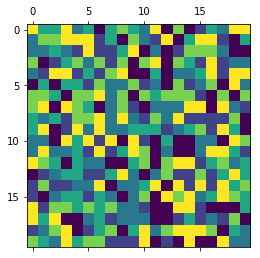

With hiuristic type 0, 46 steps were needed to solve the game
Total time taken to solve was 6.14971661567688 seconds
Total number of state visited is 202


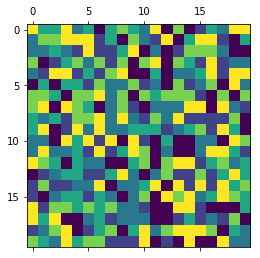

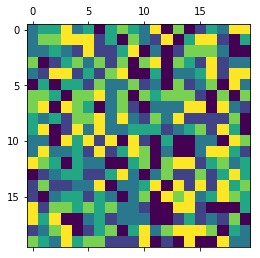

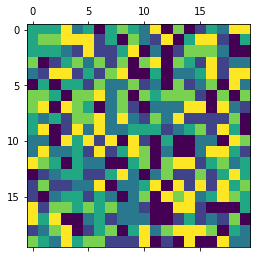

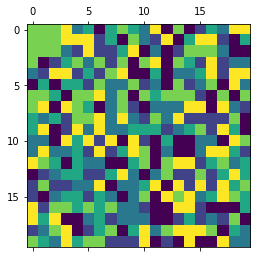

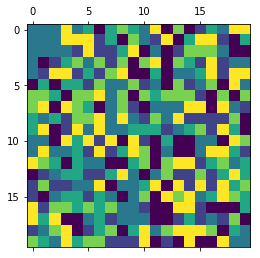

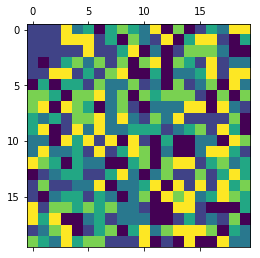

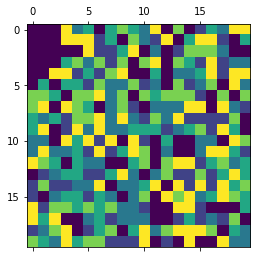

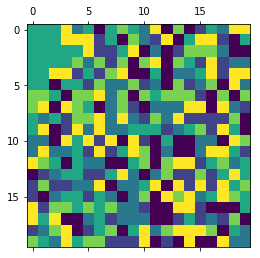

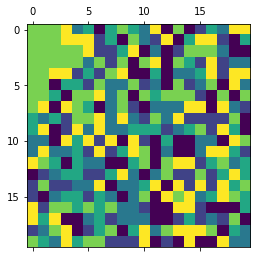

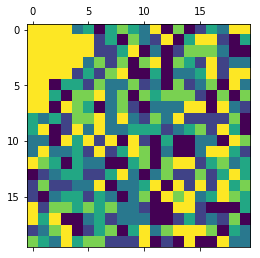

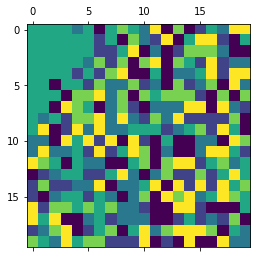

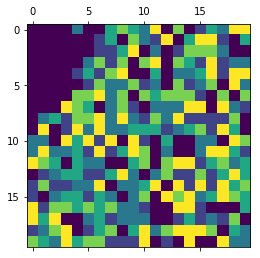

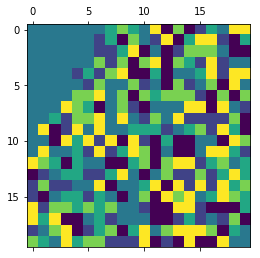

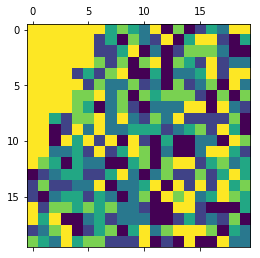

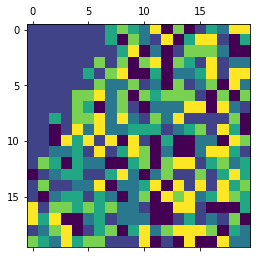

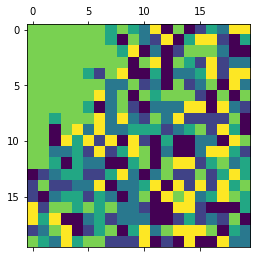

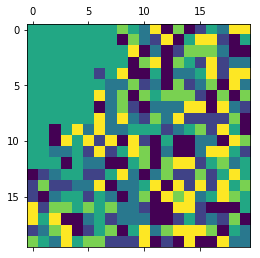

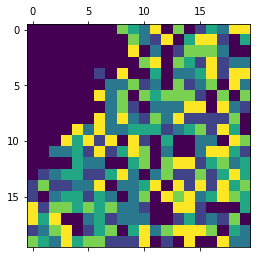

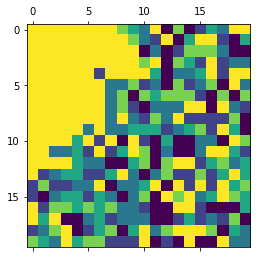

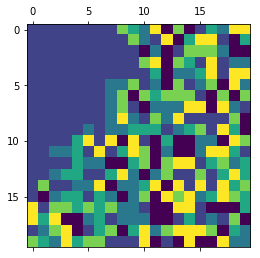

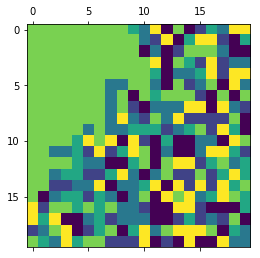

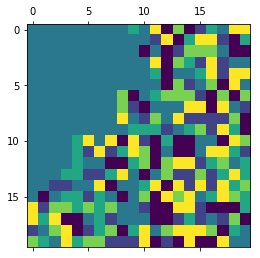

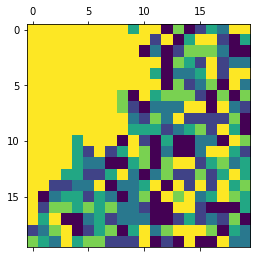

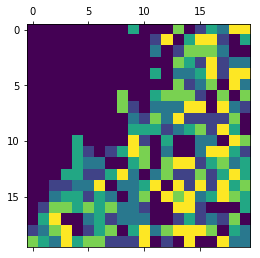

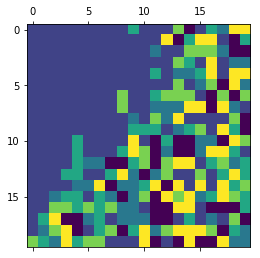

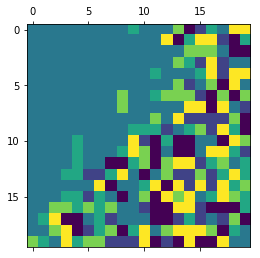

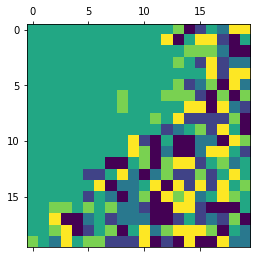

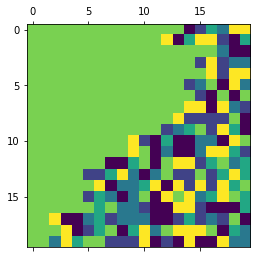

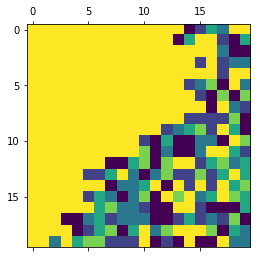

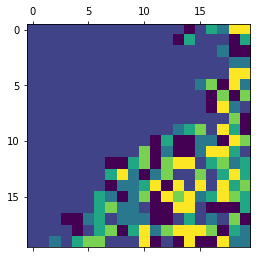

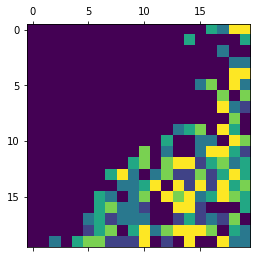

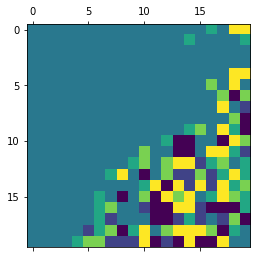

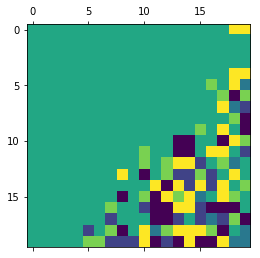

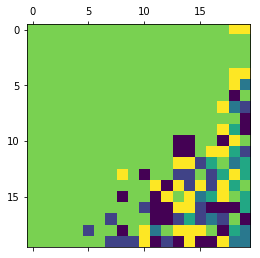

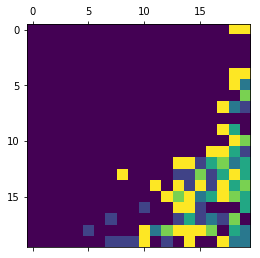

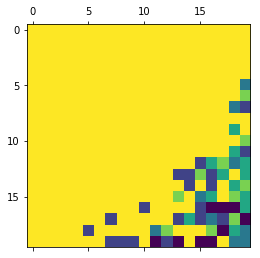

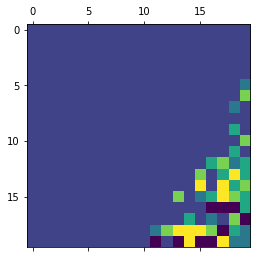

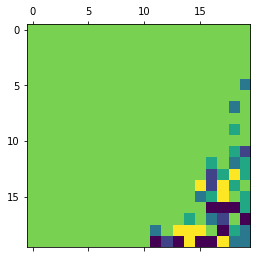

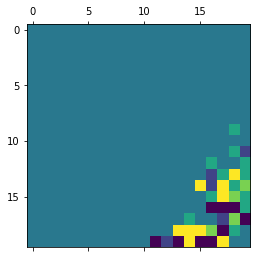

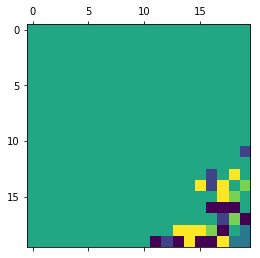

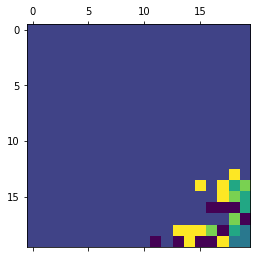

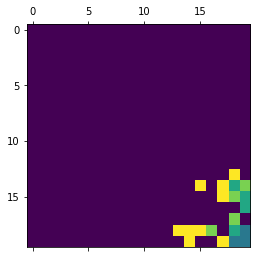

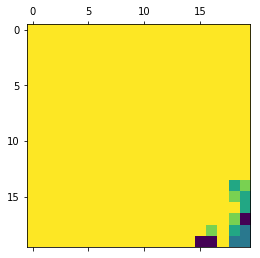

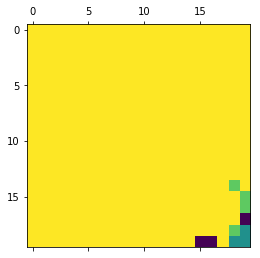

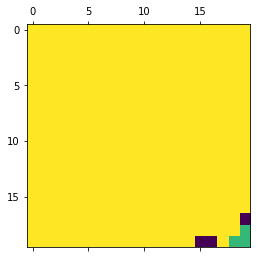

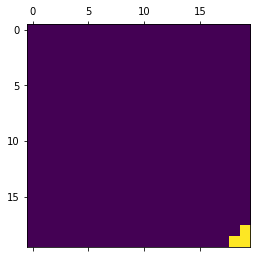

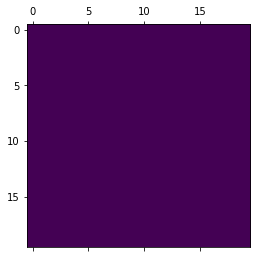

In [6]:
board = np.random.randint(6, size=(20,20))
st = make_state(board)

#solve_bfs(st)
solve_a_star(st, 0)
#solve_a_star(st, 1)